In [218]:
# importing libraries
# algorithm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier

# preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler, LabelEncoder
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import shap

# statistical test 
from scipy.stats import skew, kurtosis, kstest, shapiro

# data manipulation
import pandas as pd
import numpy as np
from math import ceil

# saving model
import pickle

# resampling method 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

# warning handling
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)
warnings.filterwarnings("ignore")

# maximizing columns and columns width
pd.set_option("display.max_colwidth", 1)
pd.set_option('display.max_columns', None)


In [219]:
df = pd.read_csv('clened_dataset.csv')
df = df.drop(columns=['Unnamed: 0'], axis=1)
df.head()

,ID,Name,Sex,Age,Team,Games,Year,Season,Sport,Medal,Host,GDP,Population
0,31,Jyri Tapani Aalto,1,31.0,Finland,2000 Summer,2000,Summer,Badminton,0,Australia,3268977.0,5176209.0
1,578,Zarinah Abdullah,0,21.0,Singapore,1992 Summer,1992,Summer,Badminton,0,Spain,2477557.0,3228231.0
2,579,Zarinah Abdullah,0,25.0,Singapore,1996 Summer,1996,Summer,Badminton,0,United States,32724488.0,3651903.0
3,757,Pablo Abin Vicen,1,23.0,Spain,2008 Summer,2008,Summer,Badminton,0,China,32844324.0,45966538.0
4,758,Pablo Abin Vicen,1,27.0,Spain,2012 Summer,2012,Summer,Badminton,0,United Kingdom,30645215.0,46756082.0


In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1542 entries, 0 to 1541
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          1542 non-null   int64  
 1   Name        1542 non-null   object 
 2   Sex         1542 non-null   int64  
 3   Age         1542 non-null   float64
 4   Team        1542 non-null   object 
 5   Games       1542 non-null   object 
 6   Year        1542 non-null   int64  
 7   Season      1542 non-null   object 
 8   Sport       1542 non-null   object 
 9   Medal       1542 non-null   int64  
 10  Host        1542 non-null   object 
 11  GDP         1542 non-null   float64
 12  Population  1542 non-null   float64
dtypes: float64(3), int64(4), object(6)
memory usage: 156.7+ KB


In [221]:
# Check for targer imbalance
df['Medal'].value_counts()

0    1336
1    70  
3    69  
2    67  
Name: Medal, dtype: int64

In [222]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
# Define target and features 
X = df.drop(columns=['Medal', 'Name', 'ID', 'Sport', 'Season'])
y = df['Medal']

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and test sets using stratified split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(X, y_encoded):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train_encoded, y_test_encoded = y_encoded[train_index], y_encoded[test_index]

In [223]:
# Define column transformer for preprocessing
numerical_features = ['Age', 'Year', 'GDP', 'Population']
categorical_features = ['Sex', 'Team', 'Host']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Define models
# Define models with class_weight='balanced'
logreg = LogisticRegression(random_state=42, class_weight='balanced')
svc = SVC(probability=True, random_state=42, class_weight='balanced')
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)

models = [
    ('Logistic Regression', logreg),
    ('SVC', svc),
    ('Random Forest', rf),
    ('XGBoost', xgb)
]

In [224]:
def tune_clf_hyperparameters(model_name, model, param_grid, X_train, y_train):

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    cv = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    cv.fit(X_train, y_train)
    best_model = cv.best_estimator_
    best_params = cv.best_params_
    return best_model, best_params

def metrics_calculator(clf, X_test, y_test, model_name):
    y_pred = clf.predict(X_test)
    
    # Compute metrics for each class
    precision_per_class = precision_score(y_test, y_pred, average=None)
    recall_per_class = recall_score(y_test, y_pred, average=None)
    f1_per_class = f1_score(y_test, y_pred, average=None)
    
    # Overall accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Combine metrics into a DataFrame
    result = pd.DataFrame({
        'Class': ['bronze', 'silver', 'gold', 'none'],  # Adjust class names as necessary
        'Precision': precision_per_class,
        'Recall': recall_per_class,
        'F1-score': f1_per_class
    })
    
    # Add overall accuracy as a separate row
    accuracy_row = pd.DataFrame({
        'Class': ['Accuracy'],
        'Precision': [accuracy],  # Accuracy is the same as precision in binary terms for overall
        'Recall': [accuracy],
        'F1-score': [accuracy]
    })
    
    result = pd.concat([result, accuracy_row], ignore_index=True)
    result.set_index('Class', inplace=True)
    result = (result * 100).round(2).astype(str) + '%'
    
    return result

# Example usage in model_evaluation function
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):
    sns.set(font_scale=1.2)
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-" * 55)
    print(classification_report(y_train, y_pred_train))
    y_pred_test = clf.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-" * 55)
    print(classification_report(y_test, y_pred_test))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=100, gridspec_kw={'width_ratios': [2, 1]})
    royalblue = LinearSegmentedColormap.from_list('royalblue', [(0, (1,1,1)), (1, (0.25,0.41,0.88))])
    royalblue_r = royalblue.reversed()
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, cmap=royalblue_r, ax=ax1)
    ax1.set_title('Confusion Matrix for Test Data')                                     
    ax1.grid(False)
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax2.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 2)
    table.set_fontsize(12)
    ax2.axis('tight')
    ax2.axis('off')
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('royalblue')
    plt.tight_layout()
    plt.show()

In [225]:
param_grid_logreg = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l2']
}

param_grid_svc = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto']
}

param_grid_rf = {
    'classifier__n_estimators': [200, 250],
    'classifier__criterion': ['entropy'],
    'classifier__max_depth': [6, 8],
    'classifier__min_samples_split': [2, 3, 4],
    'classifier__min_samples_leaf': [1, 2, 3],
    'classifier__class_weight': [{0: 1, 1: w} for w in [1, 2, 3]]
}

param_grid_xgb = {
    'classifier__n_estimators': [200, 250],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__max_depth': [7, 8],
    'classifier__subsample': [0.7, 0.8],
    'classifier__colsample_bytree': [0.8, 0.9],
    'classifier__scale_pos_weight': [1, (y_train_encoded == 0).sum() / (y_train_encoded == 1).sum()],
}


Logistic Regression Optimal Hyperparameters: 
 {'classifier__C': 0.1, 'classifier__penalty': 'l2'}

	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.76      0.86       935
           1       0.18      0.31      0.23        49
           2       0.16      0.43      0.23        47
           3       0.22      0.65      0.33        48

    accuracy                           0.72      1079
   macro avg       0.38      0.53      0.41      1079
weighted avg       0.87      0.72      0.78      1079


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.74      0.84       401
           1       0.03      0.05      0.04        21
           2       0.13      0.35      0.19        20
           3       0.12      0.43      0.19        21


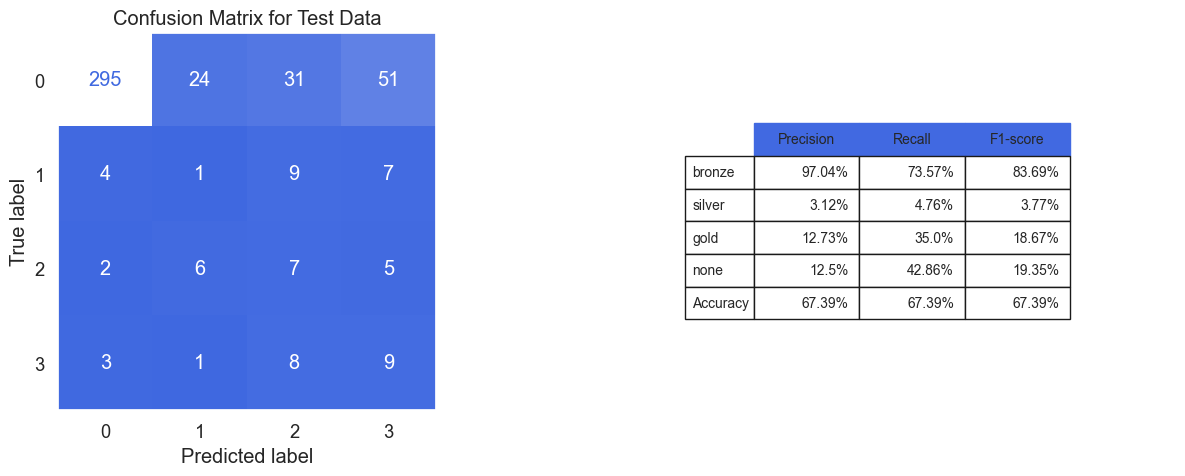

In [226]:
# Tunning and evaluating model
best_logreg, best_params_logreg = tune_clf_hyperparameters('Logistic Regression', logreg, param_grid_logreg, X_train, y_train_encoded)
print('Logistic Regression Optimal Hyperparameters: \n', best_params_logreg)
model_evaluation(best_logreg, X_train, X_test, y_train_encoded, y_test_encoded, 'Logistic Regression')

SVC Optimal Hyperparameters: 
 {'classifier__C': 0.1, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}

	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       935
           1       0.00      0.00      0.00        49
           2       0.00      0.00      0.00        47
           3       0.20      0.48      0.28        48

    accuracy                           0.83      1079
   macro avg       0.28      0.35      0.30      1079
weighted avg       0.80      0.83      0.81      1079


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       401
           1       0.00      0.00      0.00        21
           2       0.00      0.00      0.00        20
           3       0.20      0.57      0.

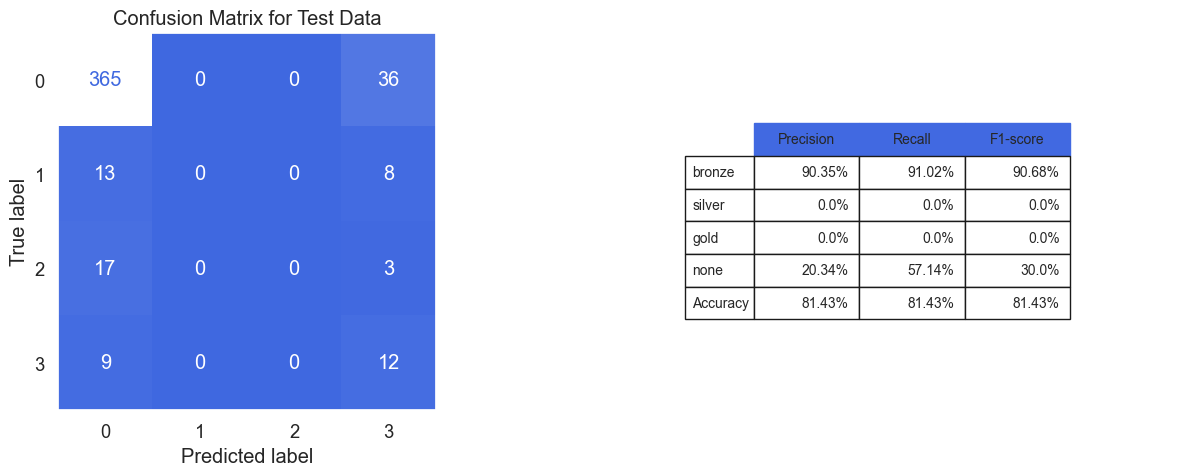

In [227]:
best_svc, best_params_svc = tune_clf_hyperparameters('SVC', svc, param_grid_svc, X_train, y_train_encoded)
print('SVC Optimal Hyperparameters: \n', best_params_svc)
model_evaluation(best_svc, X_train, X_test, y_train_encoded, y_test_encoded, 'SVC')

Random Forest Optimal Hyperparameters: 
 {'classifier__class_weight': {0: 1, 1: 2}, 'classifier__criterion': 'entropy', 'classifier__max_depth': 6, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 250}

	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       935
           1       0.80      0.08      0.15        49
           2       0.00      0.00      0.00        47
           3       0.00      0.00      0.00        48

    accuracy                           0.87      1079
   macro avg       0.42      0.27      0.27      1079
weighted avg       0.79      0.87      0.81      1079


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       401
         

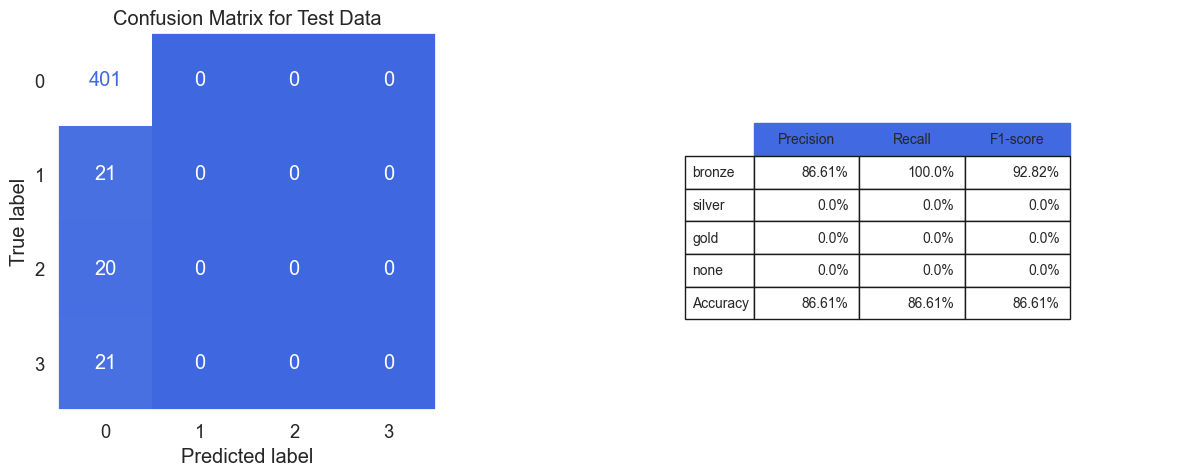

In [228]:
best_rf, best_params_rf = tune_clf_hyperparameters('Random Forest', rf, param_grid_rf, X_train, y_train_encoded)
print('Random Forest Optimal Hyperparameters: \n', best_params_rf)
model_evaluation(best_rf, X_train, X_test, y_train_encoded, y_test_encoded, 'Random Forest')

XGBoost Optimal Hyperparameters: 
 {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 7, 'classifier__n_estimators': 200, 'classifier__scale_pos_weight': 1, 'classifier__subsample': 0.7}

	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       935
           1       0.71      0.20      0.32        49
           2       1.00      0.09      0.16        47
           3       0.78      0.58      0.67        48

    accuracy                           0.90      1079
   macro avg       0.85      0.47      0.52      1079
weighted avg       0.90      0.90      0.88      1079


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       401
           1       0.00    

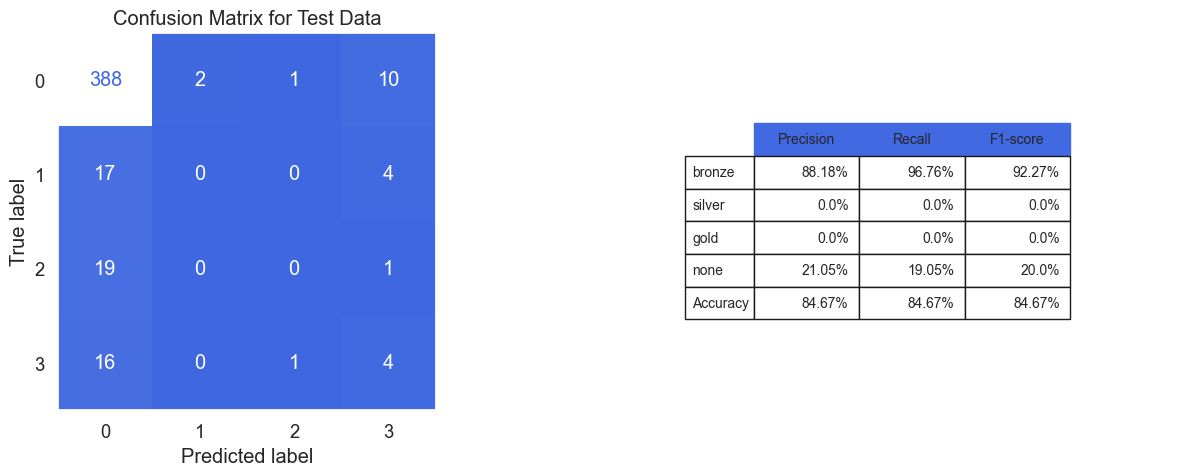

In [229]:
best_xgb, best_params_xgb = tune_clf_hyperparameters('XGBoost', xgb, param_grid_xgb, X_train, y_train_encoded)
print('XGBoost Optimal Hyperparameters: \n', best_params_xgb)
model_evaluation(best_xgb, X_train, X_test, y_train_encoded, y_test_encoded, 'XGBoost')

In [230]:
# Fit the best rf model on the entire dataset (both training and testing data)
final_model = best_svc

# Display the final model
final_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  ['Age', 'Year', 'GDP',
                                                   'Population']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'Team', 'Host'])])),
                ('classifier',
                 SVC(C=0.1, class_weight='balanced', gamma='auto',
                     probability=True, random_state=42))])

In [231]:
# Save the final model to a file named "model_hotel_booking_cancellation.sav" using pickle
pickle.dump(final_model, open("badminton_olympic_prediction", "wb"))

In [232]:
model_loaded = pickle.load(open('badminton_olympic_prediction','rb'))

In [235]:
data_baru = pd.DataFrame({
    'Age': [24],
    'Year': [2024],
    'GDP': [1.19e12],  
    'Population': [273.5e6], 
    'Sex': ['F'],
    'Team': ['Indonesia'],
    'Host': ['Paris'] 
})

# Prediksi menggunakan model
data_baru['medal_prediction'] = model_loaded.predict(data_baru)
data_baru


,Age,Year,GDP,Population,Sex,Team,Host,medal_prediction
0,24,2024,1.190000e+12,273500000.0,F,Indonesia,Paris,2
